In [ ]:
import pandas as pd

from sklearn.preprocessing import StandardScaler

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
### data ###
# text data
df_bert = pd.read_csv('/content/id_lyrics_bert_mmsr.tsv', delimiter='\t')
# audio_data
df_ivec1024 = pd.read_csv('/content/id_ivec1024_mmsr.tsv', delimiter='\t')

In [ ]:
print(df_bert.shape)
print(df_ivec1024.shape)
merged_df = pd.merge(df_bert, df_ivec1024, on='id', how='inner')
merged_df.shape

common_ids = set(df_bert['id']).intersection(df_ivec1024['id'])
print(len(common_ids))

# Filter rows based on common IDs
df_bert_filtered = df_bert[df_bert['id'].isin(common_ids)]
df_ivec1024_filtered = df_ivec1024[df_ivec1024['id'].isin(common_ids)]
print(df_bert_filtered.shape)
print(df_ivec1024_filtered.shape)

df_bert_filtered = df_bert_filtered.sort_values(by='id')
df_ivec1024_filtered = df_ivec1024_filtered.sort_values(by='id')

print(df_bert_filtered.head())
print(df_ivec1024_filtered.head())

(10095, 769)
(10094, 401)
10094
(10094, 769)
(10094, 401)
                    id         0         1         2         3         4  \
2510  01Yfj2T3YTwJ1Yfy  0.030248  0.035250  0.010701 -0.017852  0.005030   
7234  01gyRHLquwXDlhkO  0.008442  0.030256  0.009980 -0.010986 -0.010572   
5591  01rMxQv6vhyE1oQX  0.049082  0.014848  0.001100 -0.041668 -0.002801   
669   02RGE9FNH65RtMS7  0.044539  0.021491  0.013988 -0.006358 -0.012424   
538   02ZnlCGZEbkfCDxo  0.051455  0.029770 -0.016069 -0.045375 -0.027675   

             5         6         7         8  ...       758       759  \
2510  0.029203 -0.012295 -0.012398  0.002489  ...  0.011177  0.016893   
7234  0.029649 -0.008099 -0.019770 -0.030974  ... -0.019329  0.024965   
5591 -0.015679 -0.050977 -0.008229 -0.046309  ... -0.056395  0.002565   
669   0.001146 -0.078330 -0.012784 -0.001277  ... -0.068477 -0.027798   
538  -0.009376  0.008376 -0.026637  0.006598  ... -0.021063 -0.027509   

           760       761       762       763  

In [ ]:
# data investigation
df_bert

In [ ]:
df_ivec1024

,id,i000,i001,i002,i003,i004,i005,i006,i007,i008,...,i390,i391,i392,i393,i394,i395,i396,i397,i398,i399
0,9ErLUJOzu2Lvqwbq,-0.369911,1.177340,1.312063,1.567216,-0.236066,1.036267,-0.865492,-1.155326,0.305451,...,-0.544016,0.478495,-0.910013,-0.110639,-0.191088,0.258979,-0.738401,-0.474054,0.019739,-0.558993
1,MTWv5ooA00iAD8Ms,-0.605797,0.635961,-0.552902,1.230392,0.523198,0.435429,0.243145,0.616434,0.078302,...,-0.180578,1.637344,0.318935,1.783739,0.084676,0.049646,0.253696,-1.441109,-0.424085,0.821698
2,mTwXhqc4op8iTl4j,0.367864,-0.009319,1.120976,-0.452208,-0.529040,-0.275539,-0.707632,-2.208474,0.172713,...,-0.559399,0.338486,0.125648,1.239078,-0.129108,0.705474,-1.129312,0.101266,-0.022682,0.007973
3,MTxLXUkaW5ujpBH5,0.308592,1.833239,-0.203128,0.152548,-0.037248,-0.960584,-0.483353,-0.003208,0.261839,...,-0.059027,0.908120,-0.699561,-0.106280,-0.280219,-0.038609,-0.422367,0.834902,0.024272,-0.235146
4,MtxPSiYt0J3CTojA,-0.021330,-0.277851,0.840534,-0.682404,0.645433,0.370425,0.245609,1.779840,0.962718,...,-0.647192,-0.032228,0.075897,-1.844057,-0.247169,0.186966,0.631511,-1.250145,-0.417009,1.638067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10089,iJ5qikPXf8yqHwDt,-0.489556,-1.590752,-1.055544,0.501307,-0.100545,0.034334,-1.766577,0.386382,0.263722,...,0.562056,-0.002621,1.149943,0.336647,0.124827,-1.806018,0.148985,-0.821534,0.870463,0.754251
10090,DOeJTu8YNGG86YAD,-0.209427,0.177156,0.119221,0.687219,-0.558698,0.283768,0.915410,-0.804636,-1.031642,...,-0.558249,-1.306290,-0.400021,-1.109373,-0.793503,-0.574168,0.245627,0.205550,-0.097612,-1.073285
10091,MAI0R67UwbKJhs1K,-0.544062,-0.596441,0.901105,-1.323611,1.445947,-1.811026,0.068929,0.488595,1.476238,...,0.720038,0.098428,-0.329312,0.421901,0.256030,1.075268,-0.663875,-0.742685,0.473152,-0.082458
10092,G2otV6WAmea6VB1f,-0.807474,-0.432094,-0.464021,0.830529,0.372313,0.444279,0.570208,0.719624,-0.131959,...,-1.083623,-1.271469,-0.599568,0.221154,-1.043171,-0.579054,0.148327,0.651413,-0.145399,-0.067233


In [ ]:
# Merge the DataFrames based on the 'id' column
merged_df = pd.merge(df_bert, df_ivec1024, on='id', how='inner')

# Count the number of common IDs
common_ids_count = merged_df.shape[0]  # or len(merged_df)

# Display the result
print(f"The number of common IDs is: {common_ids_count}")

The number of common IDs is: 10094


In [ ]:
merged_df

,id,0,1,2,3,4,5,6,7,8,...,i390,i391,i392,i393,i394,i395,i396,i397,i398,i399
0,h48f46ZsT9h0Z5Dm,-0.015378,0.041258,-0.004096,-0.061025,-0.012853,0.028773,-0.045051,-0.016451,-0.007118,...,-0.227345,0.482069,2.767468,-0.286654,-1.658083,0.555314,-1.157564,0.593307,-0.388410,0.238668
1,PV5EXN6AIVBqvsLO,0.040497,0.061796,-0.017192,-0.012942,-0.040331,0.019082,0.001662,-0.036522,-0.022991,...,-0.073239,0.377861,-0.341285,0.537099,0.010538,0.038873,0.279586,-0.499108,0.799052,0.816284
2,z0PzOinYUixzCTGQ,0.002563,0.024931,-0.021617,-0.016013,0.002885,-0.016344,-0.070383,-0.032799,-0.004034,...,0.626024,-0.183688,1.209638,0.146052,0.288166,0.839390,1.342426,-0.122726,0.214177,0.101940
3,LZUFTnAB77X15RSz,-0.006931,0.058650,0.009551,-0.046672,0.002760,-0.041869,-0.046719,-0.006524,-0.017413,...,0.375322,-0.426760,-0.523948,-1.157001,-1.034729,-2.167635,0.080689,-0.656942,0.360479,0.628538
4,nASk24WIR6Eihbut,0.011613,0.034645,-0.009625,-0.029288,0.011753,0.009602,-0.018495,-0.026956,-0.023878,...,-0.773344,-0.163873,-1.124508,-0.075918,0.760881,0.717122,-0.567008,-0.963207,0.546956,0.195492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10089,Nf7kGQ8vllPrMe7t,0.037281,-0.028969,0.003122,-0.023138,-0.023893,0.026359,-0.010039,0.006392,-0.023590,...,0.006760,0.470569,0.914730,-0.588878,0.193280,0.074119,1.199789,-0.189216,-0.104951,-1.583193
10090,SugxX3euhXsUymSb,0.007440,0.060787,-0.015035,-0.013225,-0.020198,0.006406,-0.034460,0.002359,-0.020973,...,0.271941,-0.538041,-1.365471,-1.004506,-1.291560,-0.928296,-0.650107,1.127214,-0.110877,0.654928
10091,vMIexSFSxwRD5JGs,0.017121,0.053608,0.002408,-0.041839,0.015315,0.031789,-0.092512,0.017625,-0.089753,...,0.271141,-0.366247,-0.385409,-1.266559,0.799103,0.515090,-1.035975,0.044835,-0.458863,1.260848
10092,qSpgB2N9PXAAu4nS,0.037198,0.027035,0.013823,-0.039463,-0.011691,-0.003587,-0.050321,-0.007597,-0.022798,...,0.878424,0.133305,0.388839,0.874901,-0.040073,-0.433085,-0.146790,-1.213760,0.016580,-0.206644


In [ ]:
merged_df.drop('id', axis=1)

,0,1,2,3,4,5,6,7,8,9,...,i390,i391,i392,i393,i394,i395,i396,i397,i398,i399
0,-0.015378,0.041258,-0.004096,-0.061025,-0.012853,0.028773,-0.045051,-0.016451,-0.007118,-0.002114,...,-0.227345,0.482069,2.767468,-0.286654,-1.658083,0.555314,-1.157564,0.593307,-0.388410,0.238668
1,0.040497,0.061796,-0.017192,-0.012942,-0.040331,0.019082,0.001662,-0.036522,-0.022991,-0.012412,...,-0.073239,0.377861,-0.341285,0.537099,0.010538,0.038873,0.279586,-0.499108,0.799052,0.816284
2,0.002563,0.024931,-0.021617,-0.016013,0.002885,-0.016344,-0.070383,-0.032799,-0.004034,0.004426,...,0.626024,-0.183688,1.209638,0.146052,0.288166,0.839390,1.342426,-0.122726,0.214177,0.101940
3,-0.006931,0.058650,0.009551,-0.046672,0.002760,-0.041869,-0.046719,-0.006524,-0.017413,-0.010101,...,0.375322,-0.426760,-0.523948,-1.157001,-1.034729,-2.167635,0.080689,-0.656942,0.360479,0.628538
4,0.011613,0.034645,-0.009625,-0.029288,0.011753,0.009602,-0.018495,-0.026956,-0.023878,0.039404,...,-0.773344,-0.163873,-1.124508,-0.075918,0.760881,0.717122,-0.567008,-0.963207,0.546956,0.195492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10089,0.037281,-0.028969,0.003122,-0.023138,-0.023893,0.026359,-0.010039,0.006392,-0.023590,0.000205,...,0.006760,0.470569,0.914730,-0.588878,0.193280,0.074119,1.199789,-0.189216,-0.104951,-1.583193
10090,0.007440,0.060787,-0.015035,-0.013225,-0.020198,0.006406,-0.034460,0.002359,-0.020973,-0.028311,...,0.271941,-0.538041,-1.365471,-1.004506,-1.291560,-0.928296,-0.650107,1.127214,-0.110877,0.654928
10091,0.017121,0.053608,0.002408,-0.041839,0.015315,0.031789,-0.092512,0.017625,-0.089753,-0.009527,...,0.271141,-0.366247,-0.385409,-1.266559,0.799103,0.515090,-1.035975,0.044835,-0.458863,1.260848
10092,0.037198,0.027035,0.013823,-0.039463,-0.011691,-0.003587,-0.050321,-0.007597,-0.022798,-0.013661,...,0.878424,0.133305,0.388839,0.874901,-0.040073,-0.433085,-0.146790,-1.213760,0.016580,-0.206644


In [ ]:
merged_ids = merged_df['id']
merged_ids

0        h48f46ZsT9h0Z5Dm
1        PV5EXN6AIVBqvsLO
2        z0PzOinYUixzCTGQ
3        LZUFTnAB77X15RSz
4        nASk24WIR6Eihbut
               ...       
10089    Nf7kGQ8vllPrMe7t
10090    SugxX3euhXsUymSb
10091    vMIexSFSxwRD5JGs
10092    qSpgB2N9PXAAu4nS
10093    76qenAf8gYlH4pfq
Name: id, Length: 10094, dtype: object

In [ ]:
# normalization of features
import torch
scaler = StandardScaler()
normalized_features = scaler.fit_transform(merged_df.drop('id', axis=1))
print('shape: ',normalized_features.shape)
normalized_features
normalized_features = torch.from_numpy(normalized_features)
normalized_features

shape:  (10094, 1168)


tensor([[-1.6513,  0.4991,  0.0257,  ...,  0.7382, -0.4686,  0.2957],
        [ 1.0826,  1.2950, -1.0948,  ..., -0.5876,  0.9883,  1.0012],
        [-0.7735, -0.1336, -1.4734,  ..., -0.1308,  0.2707,  0.1287],
        ...,
        [-0.0612,  0.9777,  0.5822,  ...,  0.0725, -0.5551,  1.5442],
        [ 0.9212, -0.0520,  1.5589,  ..., -1.4549,  0.0283, -0.2483],
        [ 1.1305, -1.6796,  0.0650,  ...,  0.9045, -0.6199, -1.2134]],
       dtype=torch.float64)

In [ ]:
normalized_features.mean()
normalized_features.std()

tensor(1.0000, dtype=torch.float64)

In [ ]:
# Create DataLoader
import torch

dataset = TensorDataset(normalized_features,torch.ones((normalized_features.shape[0],1)) )
# dataset = TensorDataset( torch.tensor(merged_df.drop('id', axis=1).values, dtype=torch.float32),torch.ones((normalized_features.shape[0],1)) )
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
for x,_ in dataloader:
  print(x)
  print(_)
  break
tesloader = DataLoader(dataset, batch_size=32, shuffle=False)

tensor([[ 1.6388e-02,  2.5043e-02, -9.1844e-04,  ..., -7.5740e-01,
          6.4091e-01, -3.6937e-01],
        [ 2.4518e-02,  4.2984e-02, -9.5903e-03,  ..., -1.1288e+00,
          6.7505e-01, -1.7795e+00],
        [ 4.8519e-02,  3.1371e-02,  1.2367e-03,  ..., -2.8462e-01,
          1.1145e+00, -2.1934e-01],
        ...,
        [ 3.8216e-02,  3.9502e-02,  2.4073e-02,  ...,  5.0378e-01,
          5.2389e-01,  4.8769e-01],
        [-1.0441e-02,  2.1178e-02,  1.5809e-02,  ...,  5.6257e-01,
         -3.0035e-01,  1.0941e+00],
        [-3.2702e-03,  8.9909e-03, -1.4112e-02,  ..., -6.1496e-01,
         -2.3611e-01, -6.8154e-01]])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
    

In [ ]:
# Auto-Encoder Network
class feature_AE(nn.Module):
  def __init__ (self,input_size, latent_size):
    super(feature_AE, self).__init__()
    self.encoder = nn.Sequential(
            nn.Linear(input_size, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 128),
            nn.ReLU(),
            nn.Linear(128, latent_size),
            nn.ReLU()
        )
    self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(),
            nn.Linear(128, 500),
            nn.ReLU(),
            nn.Linear(500, 1000),
            nn.ReLU(),
            nn.Linear(1000, input_size)
            #nn.Sigmoid()  # Sigmoid activation for reconstruction in [0, 1]
        )

  def forward(self,x):
    latent_vec = self.encoder(x)
    output = self.decoder(latent_vec)
    return output

In [ ]:
input_size = normalized_features.shape[1]
hidden_size = 100
model = feature_AE(input_size , hidden_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: ',device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

Device:  cuda:0


In [ ]:
# training
train_loss = []
model.to(device)
epochs = 50
for e in range(epochs):
  losses = 0
  for x,_ in (dataloader):
    x = x.to(device, dtype=torch.float)
    optimizer.zero_grad()
    out = model(x)
    loss = criterion(out,x)
    loss.backward()
    optimizer.step()
    losses += loss.item()
  train_loss.append(losses/len(dataloader))
  print(f'Training_loss for epoch {e+1}/{epochs} ----> {losses/len(dataloader):.4f}')

Training_loss for epoch 1/50 ----> 4424038681.4300
Training_loss for epoch 2/50 ----> 15568902120593046.0000
Training_loss for epoch 3/50 ----> 14424.0724
Training_loss for epoch 4/50 ----> 0.2171
Training_loss for epoch 5/50 ----> 0.2174
Training_loss for epoch 6/50 ----> 0.2181
Training_loss for epoch 7/50 ----> 12354.1997
Training_loss for epoch 8/50 ----> 0.2263
Training_loss for epoch 9/50 ----> 10723.8106
Training_loss for epoch 10/50 ----> 0.2190
Training_loss for epoch 11/50 ----> 5900.1298
Training_loss for epoch 12/50 ----> 0.2196
Training_loss for epoch 13/50 ----> 4246.6308
Training_loss for epoch 14/50 ----> 0.2220
Training_loss for epoch 15/50 ----> 3158.9995
Training_loss for epoch 16/50 ----> 0.2189
Training_loss for epoch 17/50 ----> 2036.4705
Training_loss for epoch 18/50 ----> 0.2257
Training_loss for epoch 19/50 ----> 531.3057
Training_loss for epoch 20/50 ----> 0.2515
Training_loss for epoch 21/50 ----> 1130.0422
Training_loss for epoch 22/50 ----> 0.2180
Training_

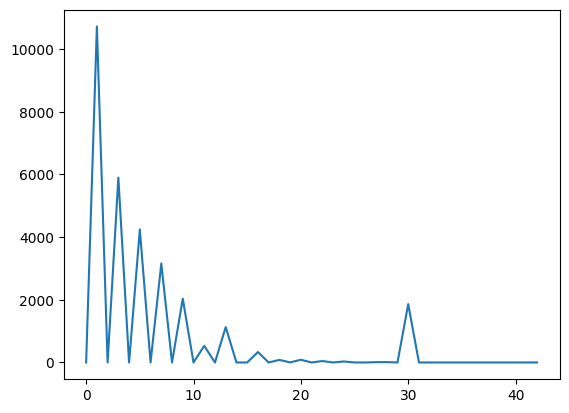

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss[7:])

In [ ]:
def get_latent_feat(data):
  for vec in data:
    latent_vec = model.encoder(vec)
    return latent_vec

In [ ]:
df = pd.read_csv('/content/id_url_mmsr.tsv', delimiter='\t')
df

,id,url
0,NDroPROgWm3jBxjH,https://www.youtube.com/watch?v=gPm2s6JORc4
1,y8wp2cUBzIEYsouc,https://www.youtube.com/watch?v=RYzQvj3icjs
2,pAzEb1oXeG9TYIvM,https://www.youtube.com/watch?v=juQ2rtxKzZk
3,x7JXGEHZv7dYCPxZ,https://www.youtube.com/watch?v=Tc9jM9DVQcA
4,KjQZmHNRq678fOJd,https://www.youtube.com/watch?v=ZgLNu57sd_8
...,...,...
10089,vHsoHHpfuEaNU0qa,https://www.youtube.com/watch?v=q15sZK-8sPw
10090,xf9WfXxEpkwo13Sa,https://www.youtube.com/watch?v=df9_tLXj-jc
10091,UIRIKK5BttiXm5C1,https://www.youtube.com/watch?v=5-0kZ_jeIHI
10092,iuC7ksd9ZI6rBDQx,https://www.youtube.com/watch?v=broClUaE4rw


In [ ]:
info = pd.read_csv('/content/id_information_mmsr.tsv', delimiter='\t')
info

,id,artist,song,album_name
0,01Yfj2T3YTwJ1Yfy,We As Human,Take The Bullets Away (feat. Lacey Sturm),We As Human
1,01gyRHLquwXDlhkO,The Notorious B.I.G.,Somebody's Gotta Die,Life After Death (Remastered Edition)
2,01rMxQv6vhyE1oQX,Against the Current,Chasing Ghosts,In Our Bones
3,02RGE9FNH65RtMS7,Barthezz,Infected,Trance - The Early Years (1997-2002)
4,02ZnlCGZEbkfCDxo,Laura Pausini,Tra Te E Il Mare,The Best of Laura Pausini - E Ritorno Da Te
...,...,...,...,...
10090,zyzILCQvVeUFIINi,Crowded House,When You Come,Temple Of Low Men
10091,zzgS4ZqyswamEWNj,Britney Spears,My Only Wish (This Year),Platinum Christmas
10092,zzoFYDMlqU1X2zz1,Thundercat,DUI,Drunk
10093,zzpkRCGA5ud8q4mv,Otis Redding,Rock Me Baby,Otis Blue


In [ ]:
from ret import get_id_from_info
query_id = get_id_from_info(song='Tra Te E Il Mare', artist= 'Laura Pausini', info=info)
query_id

'02ZnlCGZEbkfCDxo'

In [ ]:
normalized_features
normalized_data = pd.concat([merged_df['id'], pd.DataFrame(normalized_features.numpy()) ], axis=1)
normalized_data

,id,0,1,2,3,4,5,6,7,8,...,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167
0,h48f46ZsT9h0Z5Dm,-1.651296,0.499116,0.025660,-1.691494,-0.115510,1.260942,-0.591705,-0.218664,0.345587,...,-0.277532,0.579302,3.410869,-0.391586,-1.980152,0.677492,-1.395574,0.738186,-0.468610,0.295661
1,PV5EXN6AIVBqvsLO,1.082572,1.294951,-1.094758,0.634551,-1.556486,0.664487,1.314330,-1.425786,-0.359629,...,-0.087804,0.450321,-0.441228,0.632452,0.062180,0.042426,0.377628,-0.587613,0.988334,1.001185
2,z0PzOinYUixzCTGQ,-0.773474,-0.133556,-1.473394,0.485993,0.709851,-1.515876,-1.625350,-1.201853,0.482588,...,0.773095,-0.244720,1.480541,0.146327,0.401986,1.026820,1.688994,-0.130821,0.270728,0.128656
3,LZUFTnAB77X15RSz,-1.237986,1.173058,1.193346,-0.997184,0.703260,-3.086877,-0.659776,0.378379,-0.111803,...,0.464443,-0.545576,-0.667567,-1.473550,-1.217190,-2.670914,0.132223,-0.779166,0.450231,0.771865
4,nASk24WIR6Eihbut,-0.330663,0.242841,-0.447348,-0.156202,1.174875,0.081035,0.491857,-0.850477,-0.399002,...,-0.949741,-0.220195,-1.411730,-0.129613,0.980572,0.876468,-0.666927,-1.150862,0.679027,0.242924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10089,Nf7kGQ8vllPrMe7t,0.925250,-2.222197,0.643275,0.141300,-0.694480,1.112339,0.836888,1.155175,-0.386221,...,0.010686,0.565068,1.115117,-0.767294,0.285849,0.085768,1.513004,-0.211515,-0.120823,-1.929635
10090,SugxX3euhXsUymSb,-0.534877,1.255863,-0.910251,0.620831,-0.500698,-0.115690,-0.159574,0.912607,-0.269941,...,0.337165,-0.683311,-1.710310,-1.283978,-1.531541,-1.146901,-0.769457,1.386157,-0.128093,0.804099
10091,vMIexSFSxwRD5JGs,-0.061153,0.977656,0.582178,-0.763395,1.361685,1.446561,-2.528279,1.830751,-3.325669,...,0.336180,-0.470678,-0.495902,-1.609746,1.027355,0.628029,-1.245553,0.072538,-0.555050,1.544194
10092,qSpgB2N9PXAAu4nS,0.921156,-0.052034,1.558879,-0.648424,-0.054550,-0.730710,-0.806742,0.313853,-0.351020,...,1.083838,0.147629,0.463479,1.052388,0.000234,-0.537940,-0.148449,-1.454944,0.028289,-0.248262


In [ ]:
# from ret import  audio_based
def audio_based(id, repr, N, sim_func):
    # return the query song's row in repr
    target_row = repr[repr['id'] == id].iloc[:, 2:].to_numpy()
    # calculate similarity score
    repr['sim_score'] = repr.apply(lambda x:sim_func(x[2:].to_numpy(),target_row), axis=1)
    # sort tracks by similarity
    sorted_repr = repr.sort_values(by='sim_score', ascending=False)
    # get the N most similar tracks
    res = sorted_repr.iloc[1: N+1]['id'].to_numpy()
    return res

In [ ]:
# query_feat = normalized_data[normalized_data['id']==query_id ].drop('id', axis=1)
# latent_query = get_latent_feat(torch.from_numpy(query_feat.to_numpy()).to(device, dtype=torch.float))
# audio_based(id, repr, N, sim_func)
latent_feat = []
for f,_ in tesloader:
  f = f.to(device, dtype=torch.float)
  latent_feat.append(model.encoder(f))
len(latent_feat)

316

In [ ]:
combined_tensor = torch.cat(latent_feat, dim=0).cpu().detach().numpy()#.reshape(1, -1)
from ret import cos_sim
repr = pd.concat([merged_df['id'], pd.DataFrame(combined_tensor ) ], axis=1)
repr.shape
from sklearn.metrics.pairwise import cosine_similarity
retrieved = audio_based('9ScGeeaW8XcxgePd', repr, 10, cos_sim )

In [ ]:
retrieved

array(['bvFPsiMCBxrID81Z', '0kFhN9KUu2eVeiqw', 'Bskczhcw4h2DANQt',
       'f4eepQQkg2ep1b4K', 'K2gMISj7br577RSV', 'SeMYV0Bu29H6c5qJ',
       'CgmAyvJeQM7erUkr', 'b0CqE3OxrpRrX5CL', 'qQfzeTtnk27BHGbi',
       'aJKXiGsF23p1kssN'], dtype=object)

In [ ]:
from ret import get_id_from_info
id = get_id_from_info(song='Every Christmas', artist='Kelly Clarkson', info=info)
id

'9ScGeeaW8XcxgePd'

In [ ]:
df[df['id']=='0kFhN9KUu2eVeiqw']

,id,url
8882,0kFhN9KUu2eVeiqw,https://www.youtube.com/watch?v=W2L6yV9fQuo


In [ ]:
genre = info = pd.read_csv('/content/id_genres_mmsr.tsv', delimiter='\t')
genre[genre['id']=='0kFhN9KUu2eVeiqw']

,id,genre
134,0kFhN9KUu2eVeiqw,"['metalcore', 'post hardcore', 'metal', 'emo',..."


In [ ]:
normalized_features.shape

torch.Size([10094, 1168])

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt


# Assuming 'feature_array' is your NumPy array
# Replace 'feature_array' with the actual name of your array

# Instantiate PCA with the desired number of components
n_components = 100
pca = PCA(n_components=n_components, random_state=42)

# Fit and transform the data
pca_result = pca.fit_transform(merged_df.drop('id', axis=1))

# Create a scatter plot for visualization
# plt.figure(figsize=(10, 8))
# plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', alpha=0.5)
# plt.title('PCA Visualization')
# plt.xlabel(f'Principal Component 1 ({round(pca.explained_variance_ratio_[0]*100, 2)}%)')
# plt.ylabel(f'Principal Component 2 ({round(pca.explained_variance_ratio_[1]*100, 2)}%)')
# plt.show()
print(round(pca.explained_variance_ratio_[0]*100, 2))
print(round(pca.explained_variance_ratio_[1]*100, 2))
print(round(pca.explained_variance_ratio_[2]*100, 2))
print(round(pca.explained_variance_ratio_[3]*100, 2))
print(round(pca.explained_variance_ratio_[4]*100, 2))

0.63
0.61
0.55
0.53
0.51


In [ ]:
feature_array.shape

(10094, 1168)

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

# Assuming 'feature_array' is your NumPy array
# Replace 'feature_array' with the actual name of your array

# Instantiate t-SNE with the desired number of components
n_components = 2
tsne = TSNE(n_components=n_components, random_state=42)

# Fit and transform the data
tsne_result = tsne.fit_transform(pca_result)

# Create a scatter plot for visualization
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='blue', alpha=0.5)
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


In [ ]:
df_tsne = pd.concat([merged_df['id'], pd.DataFrame(tsne_result)], axis=1)
df_tsne

,id,0,1
0,h48f46ZsT9h0Z5Dm,43.166435,47.661644
1,PV5EXN6AIVBqvsLO,-62.846062,-15.023873
2,z0PzOinYUixzCTGQ,-69.073311,-53.201012
3,LZUFTnAB77X15RSz,40.088295,-26.582304
4,nASk24WIR6Eihbut,81.474770,-34.451530
...,...,...,...
10089,Nf7kGQ8vllPrMe7t,-33.482311,61.279537
10090,SugxX3euhXsUymSb,13.990068,-84.455223
10091,vMIexSFSxwRD5JGs,34.688812,4.378759
10092,qSpgB2N9PXAAu4nS,80.438538,-16.173616


In [ ]:
# df_normalized(normalized_features)
df_normalized = pd.concat([merged_df['id'], pd.DataFrame(normalized_features)], axis=1)

In [ ]:
from ret import audio_based, cos_sim
retrieved = audio_based('9ScGeeaW8XcxgePd', df_normalized, 10, cos_sim )
retrieved

array(['zzgS4ZqyswamEWNj', 'zHozLx4GhJsG7xLJ', 'dyPSAz5u5gGVbs9R',
       '2Az0PKVYczGuQejd', 'cZq0NEOrY3Ub5Bqc', '1nAyrlJRxUadsEl8',
       'fRNESz7CwtzIGozb', 'qES5o94VP8t2XZTT', 'jOh6Ui59gqd0iVvA',
       'u8bj2RyzoYZ99dWB'], dtype=object)

In [ ]:
df[df['id']=='dyPSAz5u5gGVbs9R']

,id,url
1252,dyPSAz5u5gGVbs9R,https://www.youtube.com/watch?v=n33TqJnQLCw


In [ ]:
genre[genre['id']=='dyPSAz5u5gGVbs9R']

,id,genre
6463,dyPSAz5u5gGVbs9R,"['jazz', 'pop', 'easy listening', 'ambient', '..."


In [ ]:
#################################################################################################################
#######################################   final #################################################################
#################################################################################################################

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from ret import get_genre, get_id_from_info, audio_based, cos_sim   #get_genre(id,genres_df)

In [ ]:
### data ###
# text data
df_bert = pd.read_csv('/content/id_lyrics_bert_mmsr.tsv', delimiter='\t')
# audio_data
df_ivec1024 = pd.read_csv('/content/id_ivec1024_mmsr.tsv', delimiter='\t')

# url info
url_df = pd.read_csv('/content/id_url_mmsr.tsv', delimiter='\t')

# info
info = pd.read_csv('/content/id_information_mmsr.tsv', delimiter='\t')

# genres
genre =  pd.read_csv('/content/id_genres_mmsr.tsv', delimiter='\t')

In [ ]:
########################
##### Auto-Encoder #####
########################

In [ ]:
### Data preparation

# Merge 2 feature DataFrames based on the 'id' column
merged_df = pd.merge(df_bert, df_ivec1024, on='id', how='inner')

# data preprocessing
scaler = StandardScaler()
normalized_features = scaler.fit_transform(merged_df.drop('id', axis=1))
print('Shape of the normalized_features: ',normalized_features.shape)
normalized_features_tensor = torch.from_numpy(normalized_features) # transform numpy to tensor
normalized_features_tensor
print(f'The mean of the data: {normalized_features.mean()} and the std is:{normalized_features.std()}')

# prepare dataloader and testlaoder
# datalaoder --> shuffle = True --> will be used to train the AE network
dataset = TensorDataset(normalized_features_tensor,torch.ones((normalized_features_tensor.shape[0],1)) )
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
# testlaoder --> shuffle = False --> will be used to get the latent space of the whole data after training the AE
tesloader = DataLoader(dataset, batch_size=32, shuffle=False)

Shape of the normalized_features:  (10094, 1168)
The mean of the data: 2.0147466262729784e-18 and the std is:1.0000000000000007


In [ ]:
# Auto-Encoder Network
class feature_AE(nn.Module):
  def __init__ (self,input_size_1,input_size_2,input_size, latent_size):
    super(feature_AE, self).__init__()

    self.clock1 = nn.Sequential(
            nn.Linear(input_size_1, 1000),
            nn.ReLU())

    self.clock2 = nn.Sequential(
            nn.Linear(input_size_2, 1000),
            nn.ReLU())


    self.encoder = nn.Sequential(
            nn.Linear(2000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 128),
            nn.ReLU(),
            nn.Linear(128, latent_size),
            nn.ReLU()
        )
    self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(),
            nn.Linear(128, 500),
            nn.ReLU(),
            nn.Linear(500, 1000),
            nn.ReLU(),
            nn.Linear(1000, input_size)
            #nn.Sigmoid()  # Sigmoid activation for reconstruction in [0, 1]
        )

  def forward(self,x1,x2):
    vec1 = self.clock(x1)
    vec2 = self.clock(x2)
    comb = torch.cat([vec1, vec2], dim=1)
    latent_vec = self.encoder(comb)
    output = self.decoder(latent_vec)
    return output

In [ ]:
# # Auto-Encoder Network
# class feature_AE(nn.Module):
#   def __init__ (self,input_size, latent_size):
#     super(feature_AE, self).__init__()
#     self.encoder = nn.Sequential(
#             nn.Linear(input_size, 1000),
#             nn.ReLU(),
#             nn.Linear(1000, 500),
#             nn.ReLU(),
#             nn.Linear(500, 128),
#             nn.ReLU(),
#             nn.Linear(128, latent_size),
#             nn.ReLU()
#         )
#     self.decoder = nn.Sequential(
#             nn.Linear(latent_size, 128),
#             nn.ReLU(),
#             nn.Linear(128, 500),
#             nn.ReLU(),
#             nn.Linear(500, 1000),
#             nn.ReLU(),
#             nn.Linear(1000, input_size)
#             #nn.Sigmoid()  # Sigmoid activation for reconstruction in [0, 1]
#         )

#   def forward(self,x):
#     latent_vec = self.encoder(x)
#     output = self.decoder(latent_vec)
#     return output

In [ ]:
# defining hyperparameters
input_size = normalized_features.shape[1]
hidden_size = 100
# model = feature_AE(input_size , hidden_size)

model = feature_AE(,input_size , hidden_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: ',device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

Device:  cpu


In [ ]:
# training
def train(model,trainloader,epochs):
  train_loss = []
  model.to(device)
  epochs = 50
  for e in range(epochs):
    losses = 0
    for x,_ in (dataloader):
      x = x.to(device, dtype=torch.float)
      optimizer.zero_grad()
      out = model(x)
      loss = criterion(out,x)
      loss.backward()
      optimizer.step()
      losses += loss.item()
    train_loss.append(losses/len(dataloader))
    print(f'Training_loss for epoch {e+1}/{epochs} ----> {losses/len(dataloader):.4f}')
train(model,dataloader,50)

Training_loss for epoch 1/50 ----> 117725626076.7462
Training_loss for epoch 2/50 ----> 1.2283
Training_loss for epoch 3/50 ----> 1.1727
Training_loss for epoch 4/50 ----> 1.1329
Training_loss for epoch 5/50 ----> 1.0613
Training_loss for epoch 6/50 ----> 1.0056
Training_loss for epoch 7/50 ----> 1.0010
Training_loss for epoch 8/50 ----> 1.0012
Training_loss for epoch 9/50 ----> 1.0015
Training_loss for epoch 10/50 ----> 1.0012
Training_loss for epoch 11/50 ----> 1.0023
Training_loss for epoch 12/50 ----> 1.0020
Training_loss for epoch 13/50 ----> 1.0020
Training_loss for epoch 14/50 ----> 1.0039
Training_loss for epoch 15/50 ----> 1.0024
Training_loss for epoch 16/50 ----> 1.0031
Training_loss for epoch 17/50 ----> 1.0022
Training_loss for epoch 18/50 ----> 1.0032
Training_loss for epoch 19/50 ----> 1.0027
Training_loss for epoch 20/50 ----> 1.0033
Training_loss for epoch 21/50 ----> 1.0043
Training_loss for epoch 22/50 ----> 1.0034
Training_loss for epoch 23/50 ----> 1.0026
Training_

In [ ]:
# plot losses
# plt.plot(train_loss[1:])

In [ ]:
# getting latent representation of the data (combined data)
def get_latent_feat(data):
  for vec in data:
    latent_vec = model.encoder(vec)
    return latent_vec

# latent representation
latent_feat = []
for f,_ in tesloader:
  f = f.to(device, dtype=torch.float)
  latent_feat.append(model.encoder(f))

latent_res = torch.cat(latent_feat, dim=0).cpu().detach().numpy() # getting latent res in cpu
repr = pd.concat([merged_df['id'], pd.DataFrame(latent_res) ], axis=1)

repr

,id,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,h48f46ZsT9h0Z5Dm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PV5EXN6AIVBqvsLO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,z0PzOinYUixzCTGQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,LZUFTnAB77X15RSz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,nASk24WIR6Eihbut,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10089,Nf7kGQ8vllPrMe7t,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10090,SugxX3euhXsUymSb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10091,vMIexSFSxwRD5JGs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10092,qSpgB2N9PXAAu4nS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# query id
query_id = get_id_from_info(song='Every Christmas', artist='Kelly Clarkson', info=info)
query_id

# retrieved id gining query
retrieved_ids = audio_based(id='9ScGeeaW8XcxgePd', repr=repr, N=10, sim_func=cos_sim )
print('The retriev ids: ',retrieved_ids)

The retriev ids:  ['bvFPsiMCBxrID81Z' '0kFhN9KUu2eVeiqw' 'Bskczhcw4h2DANQt'
 'f4eepQQkg2ep1b4K' 'K2gMISj7br577RSV' 'SeMYV0Bu29H6c5qJ'
 'CgmAyvJeQM7erUkr' 'b0CqE3OxrpRrX5CL' 'qQfzeTtnk27BHGbi'
 'aJKXiGsF23p1kssN']


In [ ]:
# # getting the genres of the retrieved ids
# #get_genre(id,genres_df)
# def id_genre(query_id,retrieved_ids,df,func):
#   retrieved_genre = []
#   for id in retrieved_ids:
#     retrieved_genre.append(get_genre(id,df))

#   query_genre = get_genre(query_id,df)
#   print(f'Query id: {query_id} ---- Query genre: {query_genre}')
#   print('---------------------------------------------------------------------------')

#   for id, ret in(zip(retrieved_ids,retrieved_genre)):
#     print(f'Retrieved id: {id} ---- Retrieved genre: {ret}')
#   return query_genre,retrieved_genre
# query_genre, retrieved_genre = id_and_url_or_genre(query_id=query_id,retrieved_ids=retrieved_ids,df=genre)

In [ ]:
# getting the genres of the retrieved ids
#get_genre(id,genres_df)
def id_and_url_or_genre(query_id,retrieved_ids,df,func):
  retrieved_g_u = []
  for id in retrieved_ids:
    retrieved_g_u.append(func(id,df))

  query_g_u = func(query_id,df)
  print(f'Query id: {query_id} ---- Query genre_or_url: {query_g_u}')
  print('---------------------------------------------------------------------------')

  for id, ret in(zip(retrieved_ids,retrieved_g_u)):
    print(f'Retrieved id: {id} ---- Retrieved genre_or_url: {ret}')
  return query_g_u, retrieved_g_u
query_genre, retrieved_genre = id_and_url_or_genre(query_id=query_id,retrieved_ids=retrieved_ids,df=genre,func=get_genre)

Query id: 9ScGeeaW8XcxgePd ---- Query genre_or_url: {'pop'}
---------------------------------------------------------------------------
Retrieved id: bvFPsiMCBxrID81Z ---- Retrieved genre_or_url: {'black metal', 'atmospheric black metal', 'post black metal', 'depressive black metal'}
Retrieved id: 0kFhN9KUu2eVeiqw ---- Retrieved genre_or_url: {'metalcore', 'post hardcore', 'emocore', 'progressive metalcore', 'metal', 'emo', 'mathcore'}
Retrieved id: Bskczhcw4h2DANQt ---- Retrieved genre_or_url: {'funk', 'soul'}
Retrieved id: f4eepQQkg2ep1b4K ---- Retrieved genre_or_url: {'indie rock', 'rock', 'psychedelic rock', 'lo fi', 'grunge'}
Retrieved id: K2gMISj7br577RSV ---- Retrieved genre_or_url: {'rock', 'alternative rock', 'gospel', 'pop rock'}
Retrieved id: SeMYV0Bu29H6c5qJ ---- Retrieved genre_or_url: {'indie rock', 'modern rock', 'punk', 'post grunge', 'pop rock', 'grunge', 'power pop', 'garage punk', 'pop', 'hard rock', 'classic rock', 'alternative rock', 'garage rock', 'alternative met

In [ ]:
def url(id,url_df):
  return url_df[url_df['id']==id].values[0]
query_url, retrieved_url = id_and_url_or_genre(query_id=query_id,retrieved_ids=retrieved_ids,df=url_df,func=url)

Query id: 9ScGeeaW8XcxgePd ---- Query genre_or_url: ['9ScGeeaW8XcxgePd' 'https://www.youtube.com/watch?v=0LRWwRpx_z8']
---------------------------------------------------------------------------
Retrieved id: bvFPsiMCBxrID81Z ---- Retrieved genre_or_url: ['bvFPsiMCBxrID81Z' 'https://www.youtube.com/watch?v=Lz735HTbs8E']
Retrieved id: 0kFhN9KUu2eVeiqw ---- Retrieved genre_or_url: ['0kFhN9KUu2eVeiqw' 'https://www.youtube.com/watch?v=W2L6yV9fQuo']
Retrieved id: Bskczhcw4h2DANQt ---- Retrieved genre_or_url: ['Bskczhcw4h2DANQt' 'https://www.youtube.com/watch?v=ZVvSt1egn9Q']
Retrieved id: f4eepQQkg2ep1b4K ---- Retrieved genre_or_url: ['f4eepQQkg2ep1b4K' 'https://www.youtube.com/watch?v=7ixUzgYq6n0']
Retrieved id: K2gMISj7br577RSV ---- Retrieved genre_or_url: ['K2gMISj7br577RSV' 'https://www.youtube.com/watch?v=RoBLujKLmWQ']
Retrieved id: SeMYV0Bu29H6c5qJ ---- Retrieved genre_or_url: ['SeMYV0Bu29H6c5qJ' 'https://www.youtube.com/watch?v=HVPzWkdhwrw']
Retrieved id: CgmAyvJeQM7erUkr ---- Retriev

In [ ]:
####################################################################################
#### retrieve tracks based on combined_normalized data (lyrics_bert + ivec1024) ####
####################################################################################

In [ ]:
# df_normalized(normalized_features)
df_normalized = pd.concat([merged_df['id'], pd.DataFrame(normalized_features_tensor)], axis=1)

# retrieve 10 tracks using combined_normalized data/featuers
retrieved_ids_norm = audio_based(id='9ScGeeaW8XcxgePd', repr=df_normalized , N=10, sim_func=cos_sim)

# retrieved genres using combined_normalized data
query_genre_norm, ret_genre_norm = id_and_url_or_genre(query_id=query_id,retrieved_ids=retrieved_ids_norm,df=genre,func=get_genre)
print('\n\n\n')
# retrieve urls using combined_normalized data
query_url_norm, ret_url_norm = id_and_url_or_genre(query_id=query_id,retrieved_ids=retrieved_ids_norm,df=url_df,func=url)

Query id: 9ScGeeaW8XcxgePd ---- Query genre_or_url: {'pop'}
---------------------------------------------------------------------------
Retrieved id: zzgS4ZqyswamEWNj ---- Retrieved genre_or_url: {'teen pop', 'rock', 'pop', 'singer songwriter', 'soundtrack', 'villancicos'}
Retrieved id: zHozLx4GhJsG7xLJ ---- Retrieved genre_or_url: {'pop'}
Retrieved id: dyPSAz5u5gGVbs9R ---- Retrieved genre_or_url: {'blues', 'jazz', 'pop', 'romantico', 'easy listening', 'swing', 'downtempo', 'ambient', 'vocal jazz'}
Retrieved id: 2Az0PKVYczGuQejd ---- Retrieved genre_or_url: {'pop'}
Retrieved id: cZq0NEOrY3Ub5Bqc ---- Retrieved genre_or_url: {'pop punk', 'pop', 'punk', 'easycore'}
Retrieved id: 1nAyrlJRxUadsEl8 ---- Retrieved genre_or_url: {'blues', 'soul', 'jazz', 'rock', 'poetry', 'pop', 'blues rock', 'folk', 'easy listening', 'downtempo', 'singer songwriter', 'acoustic rock', 'ambient', 'soft rock', 'pop rock'}
Retrieved id: fRNESz7CwtzIGozb ---- Retrieved genre_or_url: {'easy listening', 'swing', '

In [ ]:
#######################################################################
##### trying late fusion  #######

######################################################

In [ ]:
# Auto-Encoder Network
class feature_AE(nn.Module):
  def __init__ (self,input_size, latent_size):
    super(feature_AE, self).__init__()
    self.encoder = nn.Sequential(
            nn.Linear(input_size, latent_size),
            # nn.ReLU()
        )
    self.decoder = nn.Sequential(
            nn.Linear(latent_size, input_size),
            #nn.Sigmoid()  # Sigmoid activation for reconstruction in [0, 1]
        )

  def forward(self,x):
    latent_vec = self.encoder(x)
    output = self.decoder(latent_vec)
    return output

In [ ]:
df_bert_ = df_bert_filtered.drop('id', axis=1)
df_ivec1024_ = df_ivec1024_filtered.drop('id', axis=1)

In [ ]:
print(df_bert_.shape)
df_ivec1024_.shape

(10094, 768)


(10094, 400)

In [ ]:
df_ivec1024_.shape[1]

400

In [ ]:
model_bert = feature_AE(df_bert_.shape[1],100)
model_ivec = feature_AE(df_ivec1024_.shape[1],10)

In [ ]:
scaler = StandardScaler()
dataset_bert = TensorDataset(torch.from_numpy(scaler.fit_transform(df_bert_)),torch.ones((df_bert_.shape[0],1)) )
dataloader_bert = DataLoader(dataset_bert, batch_size=32, shuffle=True)

dataset_ivec = TensorDataset(torch.from_numpy(scaler.fit_transform(df_ivec1024_)),torch.ones((df_ivec1024_.shape[0],1)) )
dataloader_ivec = DataLoader(dataset_ivec, batch_size=32, shuffle=True)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: ',device)

criterion = nn.MSELoss()
optimizer_bert = optim.SGD(model_bert.parameters(), lr=0.000001)
optimizer_ivec = optim.SGD(model_ivec.parameters(), lr=0.000001)

Device:  cuda:0


In [ ]:
# training
def train(model,optimizer,trainloader,epochs):
  train_loss = []
  model.to(device)
  for e in range(epochs):
    losses = 0
    for x,_ in (trainloader):
      x = x.to(device, dtype=torch.float)
      optimizer.zero_grad()
      out = model(x)
      loss = criterion(out,x)
      loss.backward()
      optimizer.step()
      losses += loss.item()
    train_loss.append(losses/len(trainloader))
    print(f'Training_loss for epoch {e+1}/{epochs} ----> {losses/len(trainloader):.4f}')


In [ ]:
train(model_bert,optimizer_bert,dataloader_bert,200)

Training_loss for epoch 1/200 ----> 1.1210
Training_loss for epoch 2/200 ----> 1.1213
Training_loss for epoch 3/200 ----> 1.1207
Training_loss for epoch 4/200 ----> 1.1208
Training_loss for epoch 5/200 ----> 1.1210
Training_loss for epoch 6/200 ----> 1.1212
Training_loss for epoch 7/200 ----> 1.1210
Training_loss for epoch 8/200 ----> 1.1210
Training_loss for epoch 9/200 ----> 1.1208
Training_loss for epoch 10/200 ----> 1.1207
Training_loss for epoch 11/200 ----> 1.1211
Training_loss for epoch 12/200 ----> 1.1209
Training_loss for epoch 13/200 ----> 1.1209
Training_loss for epoch 14/200 ----> 1.1210
Training_loss for epoch 15/200 ----> 1.1208
Training_loss for epoch 16/200 ----> 1.1207
Training_loss for epoch 17/200 ----> 1.1205
Training_loss for epoch 18/200 ----> 1.1205
Training_loss for epoch 19/200 ----> 1.1207
Training_loss for epoch 20/200 ----> 1.1209
Training_loss for epoch 21/200 ----> 1.1206
Training_loss for epoch 22/200 ----> 1.1211
Training_loss for epoch 23/200 ----> 1.12

In [ ]:
model_ivec = feature_AE(df_ivec1024_.shape[1],64)
optimizer_ivec = optim.Adam(model_ivec.parameters(), lr=0.001)
train(model_ivec,optimizer_ivec,dataloader_ivec,200)

Training_loss for epoch 1/200 ----> 0.8835
Training_loss for epoch 2/200 ----> 0.8007
Training_loss for epoch 3/200 ----> 0.7826
Training_loss for epoch 4/200 ----> 0.7732
Training_loss for epoch 5/200 ----> 0.7674
Training_loss for epoch 6/200 ----> 0.7642
Training_loss for epoch 7/200 ----> 0.7620
Training_loss for epoch 8/200 ----> 0.7604
Training_loss for epoch 9/200 ----> 0.7595
Training_loss for epoch 10/200 ----> 0.7593
Training_loss for epoch 11/200 ----> 0.7588
Training_loss for epoch 12/200 ----> 0.7582
Training_loss for epoch 13/200 ----> 0.7576
Training_loss for epoch 14/200 ----> 0.7575
Training_loss for epoch 15/200 ----> 0.7572
Training_loss for epoch 16/200 ----> 0.7571
Training_loss for epoch 17/200 ----> 0.7570
Training_loss for epoch 18/200 ----> 0.7565
Training_loss for epoch 19/200 ----> 0.7565
Training_loss for epoch 20/200 ----> 0.7563
Training_loss for epoch 21/200 ----> 0.7562
Training_loss for epoch 22/200 ----> 0.7562
Training_loss for epoch 23/200 ----> 0.75

In [ ]:
latent_bert = []
for x,_ in dataloader_bert:
  latent = model_bert.encoder.to(device)(x.to(device,dtype=torch.float))
  latent_bert.append(latent)

In [ ]:
latent_ivec = []
for x,_ in dataloader_ivec:
  latent = model_ivec.encoder.to(device)(x.to(device,dtype=torch.float))
  latent_ivec.append(latent)

In [ ]:
result_tensor_ivec.shape #== result_tensor_ivec.shape

torch.Size([10094, 64])

In [ ]:
# Concatenate along the X-axis (axis=1)
result_tensor_bert = torch.cat(latent_bert, dim=0)
result_tensor_ivec = torch.cat(latent_ivec, dim=0)
print(result_tensor_bert.shape)

result_tensor = torch.cat([result_tensor_bert, result_tensor_ivec], dim=1)

torch.Size([10094, 100])


In [ ]:
#get_genre(id,genres_df)
def id_and_url_or_genre(query_id,retrieved_ids,df,func):
  retrieved_g_u = []
  for id in retrieved_ids:
    retrieved_g_u.append(func(id,df))

  query_g_u = func(query_id,df)
  print(f'Query id: {query_id} ---- Query genre_or_url: {query_g_u}')
  print('---------------------------------------------------------------------------')

  for id, ret in(zip(retrieved_ids,retrieved_g_u)):
    print(f'Retrieved id: {id} ---- Retrieved genre_or_url: {ret}')
  return query_g_u, retrieved_g_u

In [ ]:
id_col = df_ivec1024_filtered['id']

res = pd.concat([id_col, pd.DataFrame(result_tensor.cpu().detach().numpy())], axis=1,ignore_index=True)
res_ = res.rename(columns={res.columns[0]: 'id'})
res_

,id,1,2,3,4,5,6,7,8,9,...,155,156,157,158,159,160,161,162,163,164
3614,01Yfj2T3YTwJ1Yfy,-0.405523,0.500622,-0.206192,0.061958,0.178980,-0.291314,0.608395,0.528848,-0.708332,...,-0.151030,-0.426583,-0.382855,-0.062068,0.084194,0.489258,-0.515435,0.285564,0.151948,-0.522709
6364,01gyRHLquwXDlhkO,1.184484,-2.023867,0.539501,0.280359,-0.742366,-2.172390,-0.536843,-0.196731,0.643236,...,-0.425850,-0.604744,-0.241742,0.500516,0.150073,-0.146636,-0.100330,-0.121295,-0.079898,0.364055
6365,01rMxQv6vhyE1oQX,0.451122,-1.071846,0.474854,1.055789,-0.615878,-0.072370,0.487550,-0.814886,-0.934373,...,-0.443990,-0.261791,-0.179421,0.067462,0.319110,0.519108,-0.389765,-0.061336,0.254241,0.282124
8025,02RGE9FNH65RtMS7,1.366033,-0.091053,2.043705,1.005484,1.527541,-0.281606,0.199959,-0.354954,0.773440,...,0.797941,0.147516,0.721107,-0.764173,-0.410778,-0.029851,-0.175638,0.942153,-0.358519,-0.129889
4304,02ZnlCGZEbkfCDxo,-0.812112,-0.476898,0.309604,-0.106190,-0.081045,-0.782383,-0.580551,1.034814,-0.282355,...,-0.095708,0.367511,0.000669,-0.294845,-0.168030,-0.002822,-0.018811,-0.185045,0.203536,-0.246438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,zyzILCQvVeUFIINi,0.548065,-0.326338,0.400824,0.521273,0.021658,-0.625925,-1.013438,-0.621403,-0.071076,...,0.455684,0.249122,0.403517,0.439901,0.219732,-0.167659,-0.023962,0.434238,0.267481,0.384064
4927,zzgS4ZqyswamEWNj,0.486658,0.069831,-0.300035,-0.302506,0.539873,-0.385849,-0.708719,-0.087128,-0.117966,...,-0.322284,-0.215214,-0.072885,-0.237462,-0.249283,0.535260,-0.245403,0.709623,-0.811006,0.128744
6044,zzoFYDMlqU1X2zz1,-1.617187,0.647578,-1.211824,-0.098778,0.230535,1.856718,1.261286,-0.262118,0.261644,...,0.798637,0.576287,-0.094195,-0.535955,0.235468,0.415500,0.120918,-0.306287,-0.291514,0.227865
6045,zzpkRCGA5ud8q4mv,0.152559,-0.407363,0.088034,0.437171,0.425683,0.853373,0.134508,-0.977736,-0.084792,...,-0.547721,-0.272208,-0.415881,-0.012359,0.002834,-0.283273,-0.465933,0.178650,-0.254834,-0.609067


In [ ]:
# info
info = pd.read_csv('/content/id_information_mmsr.tsv', delimiter='\t')

# genres
genre =  pd.read_csv('/content/id_genres_mmsr.tsv', delimiter='\t')
url_df = pd.read_csv('/content/id_url_mmsr.tsv', delimiter='\t')
# query id
# query_id = get_id_from_info(song='Every Christmas', artist='Kelly Clarkson', info=info)
# query_id

# retrieved id gining query
# retrieved_ids = audio_based(id='9ScGeeaW8XcxgePd', repr=repr, N=10, sim_func=cos_sim )
# print('The retriev ids: ',retrieved_ids)

In [ ]:
def url(id,url_df):
  return url_df[url_df['id']==id].values[0]

In [ ]:
# retrieve 10 tracks using combined_normalized data/featuers
query_id = selected_ids[814]
retrieved_ids_norm = audio_based(id=selected_ids[814], repr=res_ , N=10, sim_func=cos_sim)

# retrieved genres using combined_normalized data
query_genre_norm, ret_genre_norm = id_and_url_or_genre(query_id=query_id,retrieved_ids=retrieved_ids_norm,df=genre,func=get_genre)
print('\n\n\n')
# retrieve urls using combined_normalized data
query_url_norm, ret_url_norm = id_and_url_or_genre(query_id=query_id,retrieved_ids=retrieved_ids_norm,df=url_df,func=url)

Query id: 4r1IjzqHAOYQlgfS ---- Query genre_or_url: {'rap', 'hip hop'}
---------------------------------------------------------------------------
Retrieved id: 5pMLWikvbUlxbw3C ---- Retrieved genre_or_url: {'pop rock', 'house', 'nu disco', 'disco', 'new wave', 'alternative dance', 'indie rock', 'synthpop', 'electronic rock', 'glam rock', 'rock', 'alternative rock', 'funk'}
Retrieved id: 37jPkefEWfJd234l ---- Retrieved genre_or_url: {'synthpop'}
Retrieved id: Ys62FSLqdMQTHRI5 ---- Retrieved genre_or_url: {'french metal', 'melodic death metal', 'progressive metal', 'progressive groove metal', 'thrash metal', 'metal', 'environmental', 'melodic groove metal', 'death metal', 'progressive rock', 'groove metal', 'rock', 'progressive death metal'}
Retrieved id: 0Eerh0X8W64EbrM9 ---- Retrieved genre_or_url: {'pop', 'britpop', 'power pop', 'electronica', 'glam rock', 'rock'}
Retrieved id: qqTmQHE6exEUldhZ ---- Retrieved genre_or_url: {'acoustic rock', 'pop', 'folk', 'soft rock', 'rock', 'altern

In [ ]:
selected_ids = info.loc[info['artist'] == 'Eminem', 'id']
selected_ids[814]

'4r1IjzqHAOYQlgfS'

In [ ]:
######################################################################################################################
######################################################################################################################
######################################################################################################################

In [ ]:
!pip install umap

In [ ]:
import numpy as np
import pandas as pd
import json
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
import umap

In [ ]:
# import utility functions
from ret import read_data # utility func to load data
from ret import get_id_from_info # utility func to return id by entering song's info
from ret import display_res # utility func to display results
from ret import get_genre #utility func to get the genres from a list of id´s
from ret import get_genre_from_query #utility func to get the id and genre from the query
from ret import get_genre_from_ids #utility func to get the id and genre from the retrieved results

# import the retrieval systems
from ret import random_baseline # baseline retrieval system that returns random results
from ret import text_based # modularized text based retrieval system
from ret import audio_based # modularized audio based retrieval system

# import wrapper function to calculate cosine similarity
from ret import cos_sim

# import evaluation functions
from ret import gen_cov_10
from ret import ndcg_score
from ret import gen_div_10
from ret import calculate_precision_at_k
# from ret import calculate_recall_at_k_vectorized
from ret import plot_precision_recall_curve
from ret import get_avg_recall_at_k
from ret import get_avg_precision_at_k

In [ ]:
"""
Please put data files in ""./data/" before use
"""

info = pd.read_csv("/content/id_information_mmsr.tsv", delimiter='\t')
genres = pd.read_csv("/content/id_genres_mmsr.tsv", delimiter='\t')

# text embeddings
bert = pd.read_csv("/content/id_lyrics_bert_mmsr.tsv", delimiter='\t')

# audio embeddings
ivec256 = pd.read_csv("/content/id_ivec256_mmsr.tsv", delimiter='\t')

#  urls
urls = pd.read_csv("/content/id_url_mmsr.tsv", delimiter='\t')

In [ ]:
common_ids = set(bert['id']).intersection(ivec256['id'])

df_bert = bert[bert['id'].isin(common_ids)].sort_values(by='id')
df_ivec256 = ivec256[ivec256['id'].isin(common_ids)].sort_values(by='id')

In [ ]:
id_col = df_bert['id']
id_col

2510    01Yfj2T3YTwJ1Yfy
7234    01gyRHLquwXDlhkO
5591    01rMxQv6vhyE1oQX
669     02RGE9FNH65RtMS7
538     02ZnlCGZEbkfCDxo
              ...       
4700    zyzILCQvVeUFIINi
8909    zzgS4ZqyswamEWNj
5523    zzoFYDMlqU1X2zz1
1341    zzpkRCGA5ud8q4mv
3487    zzx8CWdM7qkxKQpC
Name: id, Length: 10094, dtype: object

In [ ]:
!pip install umap-learn

In [ ]:
def umap_func(vect):
  embedding_array = np.asarray(vect)
  umap_model = umap.UMAP(n_neighbors=4, min_dist=0.8, n_components=100)  # Adjust parameters as needed
  print("Starting UMAP")
  embedding_umap = umap_model.fit_transform(embedding_array)
  return embedding_umap

In [ ]:
def pca_func(vect):
  n_components = 100  # You can adjust this based on your requirements

  # Perform PCA
  pca = PCA(n_components=n_components)
  principal_components = pca.fit_transform(vect)
  return principal_components

In [ ]:
pca_bert = pca_func(df_bert.drop(columns='id'))

In [ ]:
pca_ivec256 = pca_func(df_ivec256.drop(columns='id'))

In [ ]:
pca_bert_df = pd.DataFrame(pca_bert)
pca_ivec256_df = pd.DataFrame(pca_ivec256)
result_df_pca = pd.concat([pca_bert_df, pca_ivec256_df], axis=1, ignore_index=True)

In [ ]:
umap_bert = umap_func(df_bert.drop(columns='id'))

In [ ]:
umap_ivec256 = umap_func(df_ivec256.drop(columns='id'))

Starting UMAP


In [ ]:
umap_bert_df = pd.DataFrame(umap_bert)
umap_ivec256_df = pd.DataFrame(umap_ivec256)

In [ ]:
result_df = pd.concat([umap_bert_df, umap_ivec256_df], axis=1, ignore_index=True)

In [ ]:
result_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,9.830970,6.584915,3.254771,9.675815,4.010979,9.665566,6.310951,8.387707,9.680165,5.110481,...,4.470831,5.616687,4.092236,4.364143,4.777520,5.824120,5.439904,4.469789,5.151408,4.104748
1,9.900719,6.580629,5.022218,9.793440,6.928310,9.716965,4.988411,7.864815,9.607427,5.679823,...,4.243965,5.598200,4.100235,4.261806,4.992892,6.079610,5.627108,4.460091,4.994409,4.241857
2,9.935330,6.593173,5.884341,9.631296,3.463991,9.616410,5.785559,8.545666,9.623676,5.483809,...,4.354768,5.666486,4.328473,4.336294,4.400808,5.917235,5.633637,4.505650,5.063187,3.946515
3,9.856651,6.605918,7.363645,9.931909,3.474272,9.621131,4.988662,8.284488,9.608384,5.267901,...,4.489862,5.681010,4.296130,4.219110,4.484882,5.823734,5.563673,4.354832,5.212801,3.985524
4,9.867114,6.597971,6.154461,9.535529,1.764171,9.594388,5.220344,8.725605,9.621199,4.712595,...,4.601749,5.754761,4.278980,4.247124,4.952640,5.944850,5.335309,4.360660,5.231717,4.110401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10089,9.962325,6.590637,4.981074,9.531871,2.658005,9.623061,5.044673,8.489828,9.701186,3.993389,...,4.727317,5.737279,4.317863,4.246555,4.525628,5.733124,5.716633,4.398149,5.021019,4.058422
10090,9.817486,6.604256,6.807193,8.186937,3.444749,9.552336,5.383049,7.271112,9.538692,5.368945,...,4.641119,5.671218,4.338938,4.068211,4.693465,5.794303,5.521039,4.347100,5.127959,4.166461
10091,9.935035,6.591437,4.126562,9.848146,5.507861,9.644636,7.054071,7.719998,9.584685,6.474581,...,4.363750,5.515402,4.163599,4.343913,4.569604,5.720546,5.482177,4.557722,5.057524,4.104411
10092,9.837478,6.609711,7.865870,9.870633,5.092159,9.726905,4.292527,7.234773,9.388565,6.074774,...,4.467834,5.596229,4.439774,4.350986,4.406163,5.751314,5.696696,4.336970,5.007127,3.884634


In [ ]:
# df_normalized(normalized_features)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalized_features = scaler.fit_transform(result_df)

normalized_features_pca = scaler.fit_transform(result_df_pca)

In [ ]:
id_col
normalised_df = pd.concat([pd.DataFrame(common_ids),pd.DataFrame(result_df)],axis=1, ignore_index=True).rename(columns={0: 'id'})
normalised_df

,id,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,ydS4NguMgrD2NgdG,9.830970,6.584915,3.254771,9.675815,4.010979,9.665566,6.310951,8.387707,9.680165,...,4.470831,5.616687,4.092236,4.364143,4.777520,5.824120,5.439904,4.469789,5.151408,4.104748
1,qVV4FFDQZfkV1LBT,9.900719,6.580629,5.022218,9.793440,6.928310,9.716965,4.988411,7.864815,9.607427,...,4.243965,5.598200,4.100235,4.261806,4.992892,6.079610,5.627108,4.460091,4.994409,4.241857
2,qGHDYOyP7HMPvxKJ,9.935330,6.593173,5.884341,9.631296,3.463991,9.616410,5.785559,8.545666,9.623676,...,4.354768,5.666486,4.328473,4.336294,4.400808,5.917235,5.633637,4.505650,5.063187,3.946515
3,eMzHNeuY01eLCJ0u,9.856651,6.605918,7.363645,9.931909,3.474272,9.621131,4.988662,8.284488,9.608384,...,4.489862,5.681010,4.296130,4.219110,4.484882,5.823734,5.563673,4.354832,5.212801,3.985524
4,snZcvLBCVs0ynrjD,9.867114,6.597971,6.154461,9.535529,1.764171,9.594388,5.220344,8.725605,9.621199,...,4.601749,5.754761,4.278980,4.247124,4.952640,5.944850,5.335309,4.360660,5.231717,4.110401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10089,8kNMyMRHqKNrFkUw,9.962325,6.590637,4.981074,9.531871,2.658005,9.623061,5.044673,8.489828,9.701186,...,4.727317,5.737279,4.317863,4.246555,4.525628,5.733124,5.716633,4.398149,5.021019,4.058422
10090,0Y5TcGlWJnW7IVdK,9.817486,6.604256,6.807193,8.186937,3.444749,9.552336,5.383049,7.271112,9.538692,...,4.641119,5.671218,4.338938,4.068211,4.693465,5.794303,5.521039,4.347100,5.127959,4.166461
10091,FrkZVimXjeSbMoJr,9.935035,6.591437,4.126562,9.848146,5.507861,9.644636,7.054071,7.719998,9.584685,...,4.363750,5.515402,4.163599,4.343913,4.569604,5.720546,5.482177,4.557722,5.057524,4.104411
10092,Znfj2Pgh3NGZ7J2b,9.837478,6.609711,7.865870,9.870633,5.092159,9.726905,4.292527,7.234773,9.388565,...,4.467834,5.596229,4.439774,4.350986,4.406163,5.751314,5.696696,4.336970,5.007127,3.884634


In [ ]:
normalised_df_pca = pd.concat([pd.DataFrame(common_ids),pd.DataFrame(normalized_features_pca)],axis=1, ignore_index=True).rename(columns={0: 'id'})
normalised_df_pca

,id,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,ydS4NguMgrD2NgdG,1.129747,-0.098793,-0.312646,2.288603,0.028243,-0.236784,-1.121572,-0.774823,0.960545,...,0.171689,-1.052062,-0.149834,-0.771033,-0.634551,-1.096071,-0.061721,-1.598130,-1.047586,-1.388919
1,qVV4FFDQZfkV1LBT,-0.092056,-1.554935,2.105140,1.735957,0.506439,0.866673,0.406242,-1.261514,0.498803,...,-0.123585,-1.746137,-1.019154,-0.450584,0.375788,-1.652264,-0.574073,-0.455439,-0.352953,-0.614514
2,qGHDYOyP7HMPvxKJ,-0.666602,0.564601,0.223430,-0.182926,0.292829,1.157663,-1.175811,-1.048126,-0.802746,...,-0.675537,-0.393449,-1.289979,-0.280115,-0.674864,0.980067,0.392224,1.774340,1.348193,0.541265
3,eMzHNeuY01eLCJ0u,-1.360080,0.417920,2.131744,1.345212,1.195580,0.961208,1.311381,2.090576,1.202493,...,-0.970780,0.416510,0.536562,-0.429936,1.465777,-0.128196,-0.790316,-0.169477,-1.034858,0.202558
4,snZcvLBCVs0ynrjD,-0.840149,1.672686,-0.122246,0.796857,0.252582,-0.464143,0.481601,-0.265197,-0.402936,...,-1.170512,1.239072,-0.352117,-0.673986,0.198148,1.821300,-0.540499,-0.955126,-0.929350,-0.763300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10089,8kNMyMRHqKNrFkUw,-0.426153,1.737686,1.400010,-0.402204,1.266020,-0.441707,-1.006112,-1.027657,0.731354,...,-0.533345,-0.623727,0.009436,1.053331,1.167377,-0.456691,0.693768,0.345232,-0.782597,0.209101
10090,0Y5TcGlWJnW7IVdK,-0.427971,-0.186580,-0.865565,-1.672272,0.304968,-0.175615,0.578089,-1.529867,0.600306,...,-1.158060,-0.163378,0.809683,-0.231754,0.558900,-1.255139,-0.342348,0.062758,-1.083046,0.973060
10091,FrkZVimXjeSbMoJr,0.941680,-0.723935,-1.189516,0.213100,-2.143540,0.897173,0.147560,-0.097445,-0.319074,...,2.234700,-0.967303,0.048326,-1.331007,-2.175339,0.314056,-0.693113,-1.861299,1.168968,0.676546
10092,Znfj2Pgh3NGZ7J2b,-1.965364,-1.230062,1.301959,-0.221683,0.782792,-1.344438,-0.729385,-0.770070,-0.309808,...,-0.136701,0.193796,2.751340,-0.334123,0.123801,1.547362,-0.329371,0.798783,-1.251452,-0.326867


In [ ]:
query_id = get_id_from_info(song='Without Me', artist='Eminem', info=info)
query_id

retrieved_ids_norm = audio_based(id=query_id, repr=normalised_df_pca , N=10, sim_func=cos_sim)

In [ ]:
retrieved_ids_norm

array(['mMNM6CqXLkXe0FUc', '3XjZWZ3sqHQotnyS', 'NH59Ht0STcKEkeJb',
       'HtMiVTif4xBOl7Z1', 'ptrIEE5tghX6ECNW', 'oahj33USrwBNIf7V',
       '8emtw5w4gqtNVod3', 'ftHI97zQ9JjcQS1X', 'IOM7IZaDjlP8w8pm',
       'BLitoGs4KHrT1tv3'], dtype=object)

In [ ]:
def url(id,url_df):
  return url_df[url_df['id']==id].values[0]

In [ ]:
query_url_norm, ret_url_norm = id_and_url_or_genre(query_id=query_id,retrieved_ids=retrieved_ids_norm,df=urls,func=url)

Query id: TYoYVKiQpzhvcatl ---- Query genre_or_url: ['TYoYVKiQpzhvcatl' 'https://www.youtube.com/watch?v=YVkUvmDQ3HY']
---------------------------------------------------------------------------
Retrieved id: nP4fQq4Ktl5UQY6e ---- Retrieved genre_or_url: ['nP4fQq4Ktl5UQY6e' 'https://www.youtube.com/watch?v=Vf0m1DWHEds']
Retrieved id: OvWDkevn5dCLHvrW ---- Retrieved genre_or_url: ['OvWDkevn5dCLHvrW' 'https://www.youtube.com/watch?v=M6PpLn_6Sa4']
Retrieved id: jbPhzvhwQYEYiy6F ---- Retrieved genre_or_url: ['jbPhzvhwQYEYiy6F' 'https://www.youtube.com/watch?v=z8aFG9KJCnA']
Retrieved id: aQWoxvBsHigMW7Xf ---- Retrieved genre_or_url: ['aQWoxvBsHigMW7Xf' 'https://www.youtube.com/watch?v=0KhscrkieMQ']
Retrieved id: BklUBBHCNF82yfYx ---- Retrieved genre_or_url: ['BklUBBHCNF82yfYx' 'https://www.youtube.com/watch?v=2LcdyotjfvI']
Retrieved id: pl1ULhJ0GW8UvC4M ---- Retrieved genre_or_url: ['pl1ULhJ0GW8UvC4M' 'https://www.youtube.com/watch?v=MiCZdvQXULE']
Retrieved id: h4gXbvphSo2EFKxk ---- Retriev